In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
%load_ext autoreload
%autoreload 3
import warnings
warnings.filterwarnings("ignore")

In [2]:
from helpers.collection_of_experiments import *

In [3]:
ds = CollectionOfExperiments.init_folder('/home/ctrsp-2024/pp2681/experiments/Feb2022/bare', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/home/ctrsp-2024/pp2681/experiments/generalization', additional_subfolder='output')

In [4]:
for RR in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    ds.remesh('R64', RR)

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2
Experiment R64 coarsegrained to R3 is created. Its identificator=R64_R3
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4
Experiment R64 coarsegrained to R5 is created. Its identificator=R64_R5
Experiment R64 coarsegrained to R6 is created. Its identificator=R64_R6
Experiment R64 coarsegrained to R7 is created. Its identificator=R64_R7
Experiment R64 coarsegrained to R8 is created. Its identificator=R64_R8


In [5]:
def sample_ssh(exp, target):
    sample = []
    for year_start in [5, 10, 15]:
        try:
            year_end = year_start + 5
            idx = slice(365*year_start, 365*year_end)
            sample.append(
                Lk_error(ds[exp].ea.isel(zi=0).sel(Time=idx).mean('Time'), ds[target].ssh_mean)[0]
            )
        except:
            sample.append(np.nan)
    return xr.DataArray(sample, dims='sample')

In [6]:
def sample_KE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        try:
            year_end = year_start + 5
            idx = slice(365*year_start, 365*year_end)
            u = ds[exp].u.sel(Time=idx)
            v = ds[exp].v.sel(Time=idx)
            h = ds[exp].h.sel(Time=idx)
    
            KE = 1e-15 * ds[exp].KE_joul(u, v, h).mean('Time').sum()
            sample.append(KE)
        except:
            sample.append(np.nan)
    return xr.DataArray(sample, dims='sample')

In [7]:
def sample_APE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        try:
            year_end = year_start + 5
            idx = slice(365*year_start, 365*year_end)
            e = ds[exp].e.sel(Time=idx)
            APE = 1e-15 * (
                ds[exp].PE_joul(e).mean('Time').sum() + 
                ds[exp].PE_ssh(e).mean('Time').sum()
            )
            sample.append(APE)
        except:
            sample.append(np.nan)
    return xr.DataArray(sample, dims='sample')

In [32]:
def sample_smag(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        try:
            year_end = year_start + 5
            idx = slice(365*year_start, 365*year_end)
            smag = ds[exp].series_diag.smag_const.sel(Time=idx)
            sample.append(smag.mean('Time'))
        except:
            sample.append(xr.DataArray([np.nan, np.nan], dims=['zl']))
    return xr.concat(sample, dim='sample')

In [89]:
def sample_CR(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        try:
            year_end = year_start + 5
            idx = slice(365*year_start, 365*year_end)
            smag = ds[exp].series_diag.CR_const.sel(Time=idx)
            sample.append(smag.mean('Time'))
        except:
            sample.append(xr.DataArray([np.nan, np.nan], dims=['zl']))
    return xr.concat(sample, dim='sample')

In [33]:
def KE(exp, target=None):
    return 1e-15 * (ds[exp].MKE_joul + ds[exp].EKE_joul).sum('zl').values

def APE(exp, target=None):
    return 1e-15 * (ds[exp].MPE_joul + ds[exp].EPE_joul + ds[exp].MPE_ssh + ds[exp].EPE_ssh).values

In [34]:
error = xr.Dataset()

In [35]:
%%time
for fun, fun_str in zip([sample_KE, sample_APE, sample_ssh, sample_smag], ['KE', 'APE', 'ssh', 'smag']):
    %time error[f'bare-{fun_str}'] = xr.concat([fun(conf,f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    %time error[f'bare-0.03-{fun_str}'] = xr.concat([fun(f'{conf}-0.03',f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    %time error[f'bare-0.01-{fun_str}'] = xr.concat([fun(f'{conf}-0.01',f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')

CPU times: user 15.9 s, sys: 2.54 s, total: 18.4 s
Wall time: 9.87 s
CPU times: user 15.9 s, sys: 2.49 s, total: 18.4 s
Wall time: 9.83 s
CPU times: user 16.3 s, sys: 2.44 s, total: 18.8 s
Wall time: 10.3 s
CPU times: user 4 s, sys: 437 ms, total: 4.44 s
Wall time: 3.37 s
CPU times: user 4.05 s, sys: 368 ms, total: 4.42 s
Wall time: 3.39 s
CPU times: user 4.08 s, sys: 372 ms, total: 4.45 s
Wall time: 3.42 s
CPU times: user 1.13 s, sys: 143 ms, total: 1.28 s
Wall time: 1.1 s
CPU times: user 1.12 s, sys: 156 ms, total: 1.28 s
Wall time: 1.09 s
CPU times: user 1.12 s, sys: 150 ms, total: 1.27 s
Wall time: 1.09 s
CPU times: user 9.67 ms, sys: 3.92 ms, total: 13.6 ms
Wall time: 13.6 ms
CPU times: user 11 ms, sys: 1 ms, total: 12 ms
Wall time: 12.1 ms
CPU times: user 9.9 ms, sys: 1.91 ms, total: 11.8 ms
Wall time: 11.9 ms
CPU times: user 1min 3s, sys: 9.1 s, total: 1min 12s
Wall time: 43.5 s


In [90]:
%%time 
for fun, fun_str in zip([sample_KE, sample_APE, sample_ssh, sample_smag, sample_CR], ['KE', 'APE', 'ssh', 'smag', 'CR']):
    # %time error[f'DbSM-GID-clip-{fun_str}'] = xr.concat([fun(f'zelong-False-ssm-False-reduce-1-{conf}',f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    # %time error[f'DbSM-SSD-clip-{fun_str}'] = xr.concat([fun(f'zelong-True-ssm-False-reduce-1-{conf}',f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    # %time error[f'DbSM-GID-{fun_str}'] = xr.concat([fun(f'zelong-False-ssm-False-reduce-0-{conf}',f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    # %time error[f'DbSM-SSD-{fun_str}'] = xr.concat([fun(f'zelong-True-ssm-False-reduce-0-{conf}',f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    # %time error[f'DMM-GID-clip-{fun_str}'] = xr.concat([fun(f'zelong-False-ssm-True-reduce-1-{conf}',f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    # %time error[f'DMM-SSD-clip-{fun_str}'] = xr.concat([fun(f'zelong-True-ssm-True-reduce-1-{conf}',f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    # %time error[f'DMM-GID-{fun_str}'] = xr.concat([fun(f'zelong-False-ssm-True-reduce-0-{conf}',f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    # %time error[f'DMM-SSD-{fun_str}'] = xr.concat([fun(f'zelong-True-ssm-True-reduce-0-{conf}',f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    # %time error[f'DMM-Reynolds-GID-clip-{fun_str}'] = xr.concat([fun(f'zelong-False-three-component-reduce-1-{conf}',f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    %time error[f'DMM-Reynolds-SSD-clip-{fun_str}'] = xr.concat([fun(f'zelong-True-three-component-reduce-1-{conf}',f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    %time error[f'DMM-Reynolds-SSD-{fun_str}'] = xr.concat([fun(f'zelong-True-three-component-reduce-0-{conf}',f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')

CPU times: user 16.2 s, sys: 2.34 s, total: 18.5 s
Wall time: 9.92 s
CPU times: user 17.1 s, sys: 2.64 s, total: 19.7 s
Wall time: 11.4 s
CPU times: user 4.15 s, sys: 452 ms, total: 4.6 s
Wall time: 3.43 s
CPU times: user 4.13 s, sys: 313 ms, total: 4.44 s
Wall time: 3.41 s
CPU times: user 1.13 s, sys: 150 ms, total: 1.28 s
Wall time: 1.1 s
CPU times: user 1.13 s, sys: 162 ms, total: 1.29 s
Wall time: 1.11 s
CPU times: user 73.4 ms, sys: 1.9 ms, total: 75.3 ms
Wall time: 75.5 ms
CPU times: user 71 ms, sys: 994 µs, total: 72 ms
Wall time: 72 ms
CPU times: user 70.4 ms, sys: 0 ns, total: 70.4 ms
Wall time: 70.7 ms
CPU times: user 71.6 ms, sys: 0 ns, total: 71.6 ms
Wall time: 71.8 ms
CPU times: user 44.1 s, sys: 6.06 s, total: 50.2 s
Wall time: 30.6 s


In [54]:
error['bare-smag'] = xr.full_like(error['bare-smag'], 0.06)
error['bare-0.03-smag'] = xr.full_like(error['bare-smag'], 0.03)
error['bare-0.01-smag'] = xr.full_like(error['bare-smag'], 0.01)

In [91]:
#error.to_netcdf('generalization-error.nc')

In [92]:
error = xr.open_dataset('generalization-error.nc')

In [57]:
%time KE('R64')

CPU times: user 36.1 ms, sys: 2.06 ms, total: 38.2 ms
Wall time: 37.2 ms


17.04075970194989

In [58]:
%time APE('R64')

CPU times: user 13.2 ms, sys: 86 µs, total: 13.3 ms
Wall time: 12.7 ms


81.31324435644875

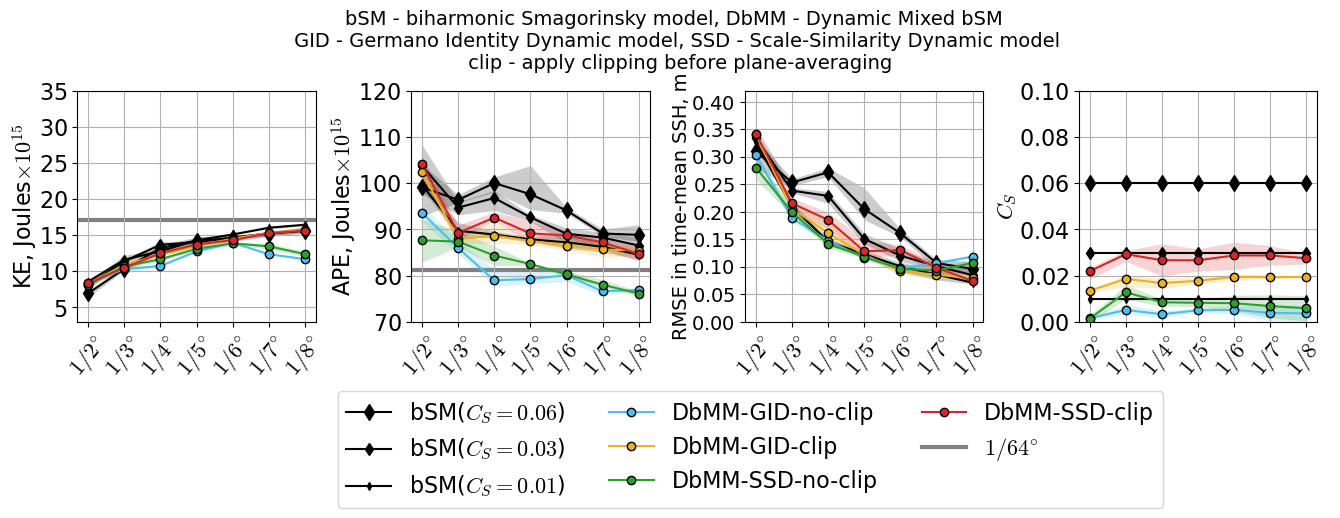

In [80]:
default_rcParams({'font.size': 16, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
plt.figure(figsize=(16,3))

yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

for row, fun_str in enumerate(['KE', 'APE', 'ssh', 'smag']):
    plt.subplot(1,4,row+1)

    def plot_markers_with_filling(model='Jansen-Held', color='tab:red', marker='s', label=None, markersize=None, lw=None):
        ave = ['zl', 'sample'] if 'zl' in error[model].dims else 'sample'
        error[model].mean(ave).plot(color=color, marker=marker, label=label, markersize=markersize, markeredgecolor='k', lw=lw)
        plt.fill_between(range(7), error[model].min(ave), error[model].max(ave), color=color, alpha=0.2, lw=0)
    
    plot_markers_with_filling(f'bare-{fun_str}', 'k', 'd', 'bSM($C_S=0.06$)', 8)
    plot_markers_with_filling(f'bare-0.03-{fun_str}', 'k', 'd', 'bSM($C_S=0.03$)', 6)
    plot_markers_with_filling(f'bare-0.01-{fun_str}', 'k', 'd', 'bSM($C_S=0.01$)', 4)

    #plot_markers_with_filling(f'DbSM-GID-{fun_str}', lightblue, 'o', 'DbSM-GID-no-clip', 6)
    #plot_markers_with_filling(f'DbSM-GID-clip-{fun_str}', yellow, 'o', 'DbSM-GID-clip', 6)
    
    #plot_markers_with_filling(f'DbSM-SSD-{fun_str}', 'tab:green', 'o', 'DbSM-SSD-no-clip', 6)
    #plot_markers_with_filling(f'DbSM-SSD-clip-{fun_str}', 'tab:red', 'o', 'DbSM-SSD-clip', 6)

    plot_markers_with_filling(f'DMM-GID-{fun_str}', lightblue, 'o', 'DbMM-GID-no-clip', 6)
    plot_markers_with_filling(f'DMM-GID-clip-{fun_str}', yellow, 'o', 'DbMM-GID-clip', 6)
    
    plot_markers_with_filling(f'DMM-SSD-{fun_str}', 'tab:green', 'o', 'DbMM-SSD-no-clip', 6)
    plot_markers_with_filling(f'DMM-SSD-clip-{fun_str}', 'tab:red', 'o', 'DbMM-SSD-clip', 6)
    
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^{\circ}$', '$1/3^{\circ}$', '$1/4^{\circ}$', '$1/5^{\circ}$', '$1/6^{\circ}$', '$1/7^{\circ}$', '$1/8^{\circ}$'],rotation=50)    
    plt.grid()
    plt.xlabel('')
    if fun_str == 'KE':
        yticks = np.arange(5,40,5)
        plt.ylabel('KE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([3,35])
        plt.axhline(y=KE('R64'),color='gray', zorder=-1,lw=3)
        #plt.text(0.0, 17.5,'$1/64^{\circ}$', color='gray')
    if fun_str == 'APE':
        yticks = np.arange(70,130,10)
        plt.ylabel('APE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([min(yticks), max(yticks)])
        plt.axhline(y=APE('R64'),color='gray',zorder=-1,lw=3)
    
    if fun_str == 'ssh':
        yticks = np.arange(0,0.45,0.05)
        plt.ylabel('RMSE in time-mean SSH, m', fontsize=14)
        plt.yticks(yticks, fontsize=14)
        plt.ylim([0,0.42])

    if fun_str == 'smag':
        plt.ylim([0,0.1])
        plt.ylabel('$C_S$')

plt.gcf().align_ylabels()
#set_letters(fontsize=18,x=0.0,y=1.05)
plt.plot(np.nan,np.nan,'-',color='gray',lw=3,label='$1/64^{\circ}$')
plt.legend(ncol=3, bbox_to_anchor=(0.4,-0.25))

plt.tight_layout()


#plt.suptitle('bSM - biharmonic Smagorinsky model, DbSM - Dynamic bSM \n GID - Germano Identity Dynamic model, SSD - Scale-Similarity Dynamic model \n clip - apply clipping before plane-averaging', y=1.15, fontsize=14)
plt.suptitle('bSM - biharmonic Smagorinsky model, DbMM - Dynamic Mixed bSM \n GID - Germano Identity Dynamic model, SSD - Scale-Similarity Dynamic model \n clip - apply clipping before plane-averaging', y=1.15, fontsize=14)
plt.savefig('figures/DbMM-metrics.pdf')

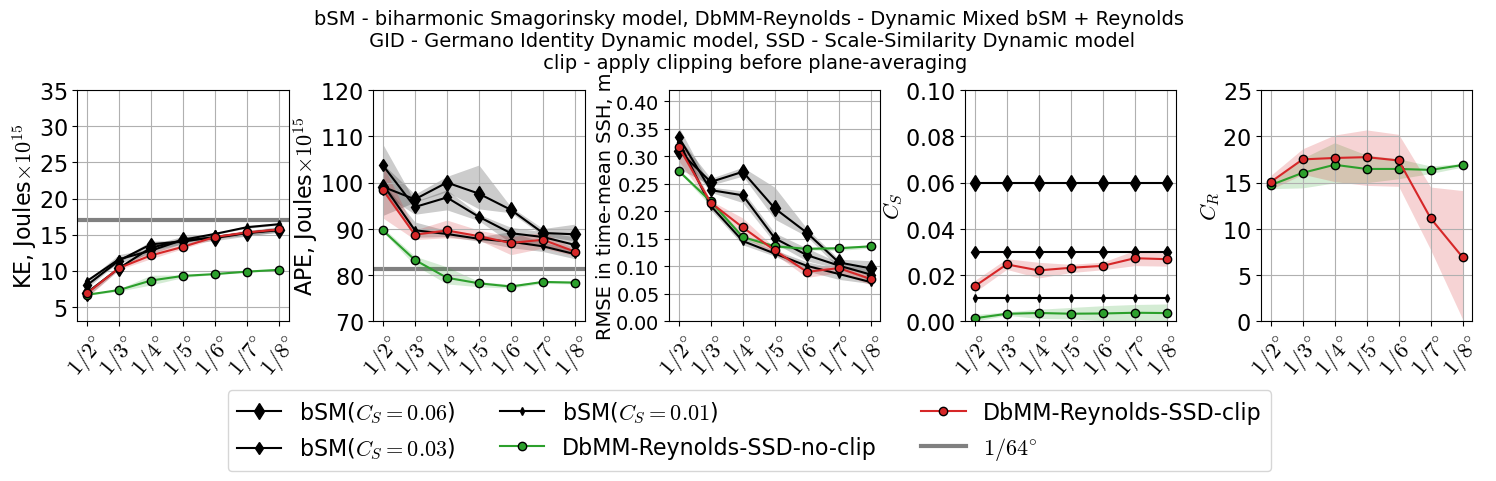

In [97]:
default_rcParams({'font.size': 16, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
plt.figure(figsize=(18,3))

yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

for row, fun_str in enumerate(['KE', 'APE', 'ssh', 'smag', 'CR']):
    plt.subplot(1,5,row+1)

    def plot_markers_with_filling(model='Jansen-Held', color='tab:red', marker='s', label=None, markersize=None, lw=None):
        try:
            ave = ['zl', 'sample'] if 'zl' in error[model].dims else 'sample'
            error[model].mean(ave).plot(color=color, marker=marker, label=label, markersize=markersize, markeredgecolor='k', lw=lw)
            plt.fill_between(range(7), error[model].min(ave), error[model].max(ave), color=color, alpha=0.2, lw=0)
        except:
            pass
    
    plot_markers_with_filling(f'bare-{fun_str}', 'k', 'd', 'bSM($C_S=0.06$)', 8)
    plot_markers_with_filling(f'bare-0.03-{fun_str}', 'k', 'd', 'bSM($C_S=0.03$)', 6)
    plot_markers_with_filling(f'bare-0.01-{fun_str}', 'k', 'd', 'bSM($C_S=0.01$)', 4)

    #plot_markers_with_filling(f'DbSM-GID-{fun_str}', lightblue, 'o', 'DbSM-GID-no-clip', 6)
    #plot_markers_with_filling(f'DbSM-GID-clip-{fun_str}', yellow, 'o', 'DbSM-GID-clip', 6)
    
    #plot_markers_with_filling(f'DbSM-SSD-{fun_str}', 'tab:green', 'o', 'DbSM-SSD-no-clip', 6)
    #plot_markers_with_filling(f'DbSM-SSD-clip-{fun_str}', 'tab:red', 'o', 'DbSM-SSD-clip', 6)

    #plot_markers_with_filling(f'DMM-GID-{fun_str}', lightblue, 'o', 'DbMM-GID-no-clip', 6)
    #plot_markers_with_filling(f'DMM-GID-clip-{fun_str}', yellow, 'o', 'DbMM-GID-clip', 6)
    
    #plot_markers_with_filling(f'DMM-SSD-{fun_str}', 'tab:green', 'o', 'DbMM-SSD-no-clip', 6)
    #plot_markers_with_filling(f'DMM-SSD-clip-{fun_str}', 'tab:red', 'o', 'DbMM-SSD-clip', 6)

    #plot_markers_with_filling(f'DMM-Reynolds-GID-{fun_str}', lightblue, 'o', 'DbMM-GID-no-clip', 6)
    #plot_markers_with_filling(f'DMM-Reynolds-GID-clip-{fun_str}', yellow, 'o', 'DbMM-Reynolds-GID-clip', 6)
    
    plot_markers_with_filling(f'DMM-Reynolds-SSD-{fun_str}', 'tab:green', 'o', 'DbMM-Reynolds-SSD-no-clip', 6)
    plot_markers_with_filling(f'DMM-Reynolds-SSD-clip-{fun_str}', 'tab:red', 'o', 'DbMM-Reynolds-SSD-clip', 6)
    
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^{\circ}$', '$1/3^{\circ}$', '$1/4^{\circ}$', '$1/5^{\circ}$', '$1/6^{\circ}$', '$1/7^{\circ}$', '$1/8^{\circ}$'],rotation=50)    
    plt.grid()
    plt.xlabel('')
    if fun_str == 'KE':
        yticks = np.arange(5,40,5)
        plt.ylabel('KE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([3,35])
        plt.axhline(y=KE('R64'),color='gray', zorder=-1,lw=3)
        #plt.text(0.0, 17.5,'$1/64^{\circ}$', color='gray')
    if fun_str == 'APE':
        yticks = np.arange(70,130,10)
        plt.ylabel('APE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([min(yticks), max(yticks)])
        plt.axhline(y=APE('R64'),color='gray',zorder=-1,lw=3)
    
    if fun_str == 'ssh':
        yticks = np.arange(0,0.45,0.05)
        plt.ylabel('RMSE in time-mean SSH, m', fontsize=14)
        plt.yticks(yticks, fontsize=14)
        plt.ylim([0,0.42])

    if fun_str == 'smag':
        plt.ylim([0,0.1])
        plt.ylabel('$C_S$')

        plt.plot(np.nan,np.nan,'-',color='gray',lw=3,label='$1/64^{\circ}$')
        plt.legend(ncol=3, bbox_to_anchor=(1.5,-0.25))

    if fun_str == 'CR':
        plt.ylim([0,25])
        plt.ylabel('$C_R$')

plt.gcf().align_ylabels()
#set_letters(fontsize=18,x=0.0,y=1.05)

plt.tight_layout()


#plt.suptitle('bSM - biharmonic Smagorinsky model, DbSM - Dynamic bSM \n GID - Germano Identity Dynamic model, SSD - Scale-Similarity Dynamic model \n clip - apply clipping before plane-averaging', y=1.15, fontsize=14)
plt.suptitle('bSM - biharmonic Smagorinsky model, DbMM-Reynolds - Dynamic Mixed bSM + Reynolds \n GID - Germano Identity Dynamic model, SSD - Scale-Similarity Dynamic model \n clip - apply clipping before plane-averaging', y=1.15, fontsize=14)
plt.savefig('figures/DbMM-Reynolds-metrics.pdf')

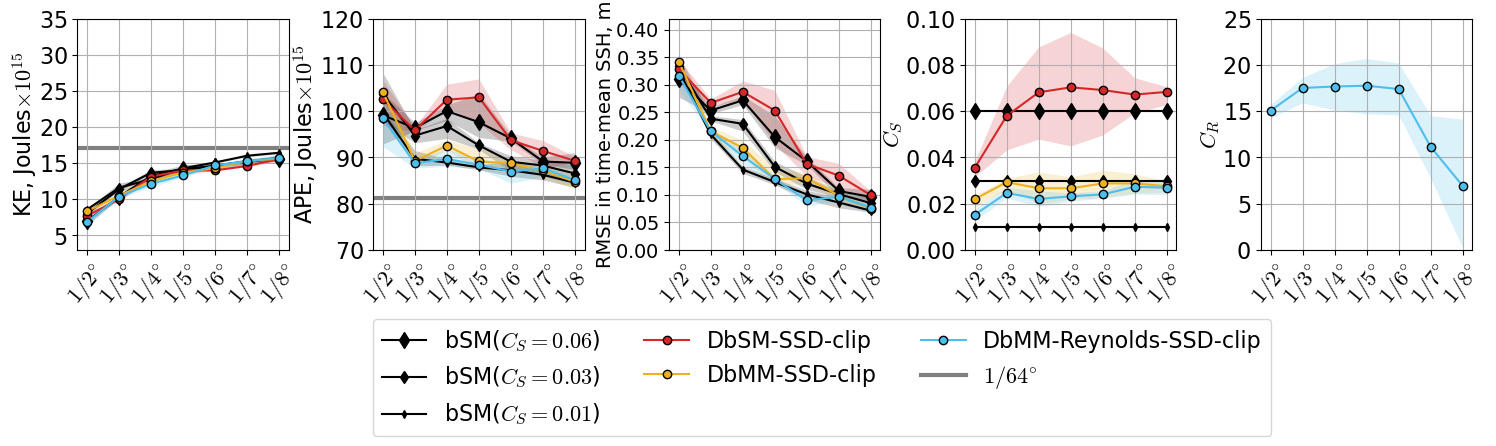

In [100]:
default_rcParams({'font.size': 16, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
plt.figure(figsize=(18,3))

yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

for row, fun_str in enumerate(['KE', 'APE', 'ssh', 'smag', 'CR']):
    plt.subplot(1,5,row+1)

    def plot_markers_with_filling(model='Jansen-Held', color='tab:red', marker='s', label=None, markersize=None, lw=None):
        try:
            ave = ['zl', 'sample'] if 'zl' in error[model].dims else 'sample'
            error[model].mean(ave).plot(color=color, marker=marker, label=label, markersize=markersize, markeredgecolor='k', lw=lw)
            plt.fill_between(range(7), error[model].min(ave), error[model].max(ave), color=color, alpha=0.2, lw=0)
        except:
            pass
    
    plot_markers_with_filling(f'bare-{fun_str}', 'k', 'd', 'bSM($C_S=0.06$)', 8)
    plot_markers_with_filling(f'bare-0.03-{fun_str}', 'k', 'd', 'bSM($C_S=0.03$)', 6)
    plot_markers_with_filling(f'bare-0.01-{fun_str}', 'k', 'd', 'bSM($C_S=0.01$)', 4)

    #plot_markers_with_filling(f'DbSM-GID-{fun_str}', lightblue, 'o', 'DbSM-GID-no-clip', 6)
    #plot_markers_with_filling(f'DbSM-GID-clip-{fun_str}', yellow, 'o', 'DbSM-GID-clip', 6)
    
    #plot_markers_with_filling(f'DbSM-SSD-{fun_str}', 'tab:green', 'o', 'DbSM-SSD-no-clip', 6)
    plot_markers_with_filling(f'DbSM-SSD-clip-{fun_str}', 'tab:red', 'o', 'DbSM-SSD-clip', 6)

    #plot_markers_with_filling(f'DMM-GID-{fun_str}', lightblue, 'o', 'DbMM-GID-no-clip', 6)
    #plot_markers_with_filling(f'DMM-GID-clip-{fun_str}', yellow, 'o', 'DbMM-GID-clip', 6)
    
    #plot_markers_with_filling(f'DMM-SSD-{fun_str}', 'tab:green', 'o', 'DbMM-SSD-no-clip', 6)
    plot_markers_with_filling(f'DMM-SSD-clip-{fun_str}', yellow, 'o', 'DbMM-SSD-clip', 6)

    #plot_markers_with_filling(f'DMM-Reynolds-GID-{fun_str}', lightblue, 'o', 'DbMM-GID-no-clip', 6)
    #plot_markers_with_filling(f'DMM-Reynolds-GID-clip-{fun_str}', yellow, 'o', 'DbMM-Reynolds-GID-clip', 6)
    
    #plot_markers_with_filling(f'DMM-Reynolds-SSD-{fun_str}', 'tab:green', 'o', 'DbMM-Reynolds-SSD-no-clip', 6)
    plot_markers_with_filling(f'DMM-Reynolds-SSD-clip-{fun_str}', lightblue, 'o', 'DbMM-Reynolds-SSD-clip', 6)
    
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^{\circ}$', '$1/3^{\circ}$', '$1/4^{\circ}$', '$1/5^{\circ}$', '$1/6^{\circ}$', '$1/7^{\circ}$', '$1/8^{\circ}$'],rotation=50)    
    plt.grid()
    plt.xlabel('')
    if fun_str == 'KE':
        yticks = np.arange(5,40,5)
        plt.ylabel('KE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([3,35])
        plt.axhline(y=KE('R64'),color='gray', zorder=-1,lw=3)
        #plt.text(0.0, 17.5,'$1/64^{\circ}$', color='gray')
    if fun_str == 'APE':
        yticks = np.arange(70,130,10)
        plt.ylabel('APE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([min(yticks), max(yticks)])
        plt.axhline(y=APE('R64'),color='gray',zorder=-1,lw=3)
    
    if fun_str == 'ssh':
        yticks = np.arange(0,0.45,0.05)
        plt.ylabel('RMSE in time-mean SSH, m', fontsize=14)
        plt.yticks(yticks, fontsize=14)
        plt.ylim([0,0.42])

    if fun_str == 'smag':
        plt.ylim([0,0.1])
        plt.ylabel('$C_S$')

        plt.plot(np.nan,np.nan,'-',color='gray',lw=3,label='$1/64^{\circ}$')
        plt.legend(ncol=3, bbox_to_anchor=(1.5,-0.25))

    if fun_str == 'CR':
        plt.ylim([0,25])
        plt.ylabel('$C_R$')

plt.gcf().align_ylabels()
#set_letters(fontsize=18,x=0.0,y=1.05)

plt.tight_layout()


#plt.suptitle('bSM - biharmonic Smagorinsky model, DbSM - Dynamic bSM \n GID - Germano Identity Dynamic model, SSD - Scale-Similarity Dynamic model \n clip - apply clipping before plane-averaging', y=1.15, fontsize=14)
#plt.suptitle('bSM - biharmonic Smagorinsky model, DbMM-Reynolds - Dynamic Mixed bSM + Reynolds \n GID - Germano Identity Dynamic model, SSD - Scale-Similarity Dynamic model \n clip - apply clipping before plane-averaging', y=1.15, fontsize=14)
plt.savefig('figures/Mixed-models-metrics.pdf')